# After all that, a dead-end

I had a hypothesis that certain words or phrases might be able to predict who defaults and who repays.  

I think this should be explored with more than 400 users, which is usually standard in the NLP world.  

Also, we should work out a smarter way with dealing with English/Swahili along with their associated unique spellings. I downloaded the Google Word2Vec, but it's from their news site. It'll map context well; however, I doubt it will map repayment/default well. You'd need to build your own word2vec architecture.

In [1]:
import os
import nltk
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import numpy as np
import re
import codecs
import lime

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import json
from pandas.io.json import json_normalize    

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

import gensim

import matplotlib.patches as mpatches

In [3]:
def build_df():
    """
    Once the files have been unzipped, let's build some dataframes from the three types of data we have:
    IE phone calls, contacts, and text messages

    :return:
    Three pandas.DataFrames [calls, contacts, sms]
    """

    # Set our top-level file path to find all the data
    origin_root = "../data/user_logs/"

    # Create multiple lists so we can concat later
    call_list = list()
    contact_list = list()
    sms_list = list()

    # TODO: research about writing on the fly when unzipping the files
    for root, dirs, files in os.walk(origin_root):
        for file in files:
            if file.endswith("collated_call_log.txt"):
                user_and_device = str(root[18:])
                user_id, device_id = user_and_device.split("/")[
                    0
                ], user_and_device.split(
                    "/"
                )[
                    1
                ]
                tmp_txt = os.path.join(root, file)
                temp_df = pd.read_json(tmp_txt)
                temp_df["user_id"] = user_id
                temp_df["device_id"] = device_id
                call_list.append(temp_df)
            elif file.endswith("collated_contact_list.txt"):
                user_and_device = str(root[18:])
                user_id, device_id = user_and_device.split("/")[
                    0
                ], user_and_device.split(
                    "/"
                )[
                    1
                ]
                tmp_txt = os.path.join(root, file)
                temp_df = pd.read_json(tmp_txt)
                temp_df["user_id"] = user_id
                temp_df["device_id"] = device_id
                contact_list.append(temp_df)
            elif file.endswith("collated_sms_log.txt"):
                user_and_device = str(root[18:])
                user_id, device_id = user_and_device.split("/")[
                    0
                ], user_and_device.split(
                    "/"
                )[
                    1
                ]
                tmp_txt = os.path.join(root, file)
                temp_df = pd.read_json(tmp_txt)
                temp_df["user_id"] = user_id
                temp_df["device_id"] = device_id
                sms_list.append(temp_df)

    # Combine the respective data in their own groupings
    call_df = pd.concat(call_list, axis=0)
    contact_df = pd.concat(contact_list, axis=0)
    sms_df = pd.concat(sms_list, axis=0)

    return call_df, contact_df, sms_df

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

def combine_messages(message_df):
     return pd.Series(dict(text = "%s" % " ".join(message_df['message_body'])))

def avg_word(sentence):
  words_ = sentence.split()
  return (sum(len(word) for word in words_)/len(words_))

In [4]:
call_df, contact_df, sms_df = build_df()

loan_df = pd.read_csv("../data/user_logs/user_status.csv", parse_dates=['disbursement_date'])
loan_df['user_id'] = "user-" + loan_df['user_id'].apply(str)
dummy_loans = pd.get_dummies(loan_df['status'])
loan_df = pd.concat([loan_df, dummy_loans], axis=1)

msg_df = sms_df.loc[(sms_df['sms_type'] == 2.0), ['user_id', 'message_body']]

In [5]:
msg_df['word_count'] = msg_df['message_body'].apply(lambda x: len(str(x).split(" ")))
msg_df['char_count'] = msg_df['message_body'].str.len() ## this also includes spaces

In [6]:
msg_df.head(11)

,user_id,message_body,word_count,char_count
1.0,user-1,Vipi?,1,5
11.0,user-1,"*Gd evening*, uliniambia utanishow leo so naom...",15,96
15.0,user-1,"Hana mahali pa kulala, sasa anataka kuleta vyo...",13,79
16.0,user-1,Morning my dear? Charles unataka kuleta vitu v...,16,103
31.0,user-1,Yap lakini anamalizia mpaka fri.( sasa ndio vi...,8,51
33.0,user-1,We niambie tu plz.,4,18
35.0,user-1,But naumia! we niambie tu,7,27
37.0,user-1,Kwani unataka kunipa cku gani wewe?,6,35
42.0,user-1,Kwani wataka kunipa lini wewe priscah?,6,38
43.0,user-1,Nko kwa nyumba,3,14


In [7]:
path_all_stopwords = "../../../../data/stopwords-json/stopwords-all.json"

with open(path_all_stopwords) as data_file:    
    data = json.load(data_file)  

stopwords_sw = json_normalize(data, ["sw"])
stopwords_sw = list(stopwords_sw.iloc[:,0])

stopwords_eng = ENGLISH_STOP_WORDS
all_stopwords = stopwords_eng.union(stopwords_sw)

In [8]:
msg_df['clean_message_body'] = msg_df['message_body'].apply(lambda x: " ".join(x.lower() for x in x.split()))
msg_df['clean_message_body'] = msg_df['clean_message_body'].str.replace('[^\w\s]','')
msg_df['clean_message_body'] = msg_df['clean_message_body'].apply(lambda x: " ".join(x for x in x.split() if x not in all_stopwords))

In [9]:
from nltk.stem import PorterStemmer
st = PorterStemmer()
msg_df['clean_message_body'] = msg_df['clean_message_body'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [10]:
from textblob import Word
msg_df['clean_message_body'] = msg_df['clean_message_body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [11]:
freq = pd.Series(' '.join(msg_df['clean_message_body']).split()).value_counts()[:33]
freq

poa      25205
u        20999
uko      14372
sawa     13854
n        11795
ama      10419
ok        9634
niko      8892
nko       8817
aki       8718
wapi      7779
love      7755
thank     7407
beb       7381
good      6966
ata       6786
si        6481
leo       6372
kesho     5909
c         5789
ndo       5764
morn      5322
hi        5277
2         5241
bado      5233
just      5167
hey       5034
bt        4927
swee      4840
time      4742
dont      4589
bro       4565
ndio      4468
dtype: int64

In [12]:
all_stopwords

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'akasema',
           'alikuwa',
           'alisema',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'baada',
           'back',
           'basi',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand

In [13]:
msg_df.head()

,user_id,message_body,word_count,char_count,clean_message_body
1.0,user-1,Vipi?,1,5,vipi
11.0,user-1,"*Gd evening*, uliniambia utanishow leo so naom...",15,96,gd even uliniambia utanishow leo naomba plz ha...
15.0,user-1,"Hana mahali pa kulala, sasa anataka kuleta vyo...",13,79,hana mahali pa kulala anataka kuleta vyombo vy...
16.0,user-1,Morning my dear? Charles unataka kuleta vitu v...,16,103,morn dear charl unataka kuleta vitu vyak hapa ...
31.0,user-1,Yap lakini anamalizia mpaka fri.( sasa ndio vi...,8,51,yap anamalizia mpaka fri ndio vipi


In [14]:
tokenizer = RegexpTokenizer(r'\w+')

exp_df = msg_df.merge(loan_df)
del exp_df['status']
del exp_df['repaid']

# exp_df = standardize_text(exp_df, "clean_message_body")

# exp_df["tokens"] = exp_df["clean_message_body"].apply(tokenizer.tokenize)

In [15]:
exp_df.head()

,user_id,message_body,word_count,char_count,clean_message_body,disbursement_date,defaulted
0,user-1,Vipi?,1,5,vipi,2017-05-29,1
1,user-1,"*Gd evening*, uliniambia utanishow leo so naom...",15,96,gd even uliniambia utanishow leo naomba plz ha...,2017-05-29,1
2,user-1,"Hana mahali pa kulala, sasa anataka kuleta vyo...",13,79,hana mahali pa kulala anataka kuleta vyombo vy...,2017-05-29,1
3,user-1,Morning my dear? Charles unataka kuleta vitu v...,16,103,morn dear charl unataka kuleta vitu vyak hapa ...,2017-05-29,1
4,user-1,Yap lakini anamalizia mpaka fri.( sasa ndio vi...,8,51,yap anamalizia mpaka fri ndio vipi,2017-05-29,1


In [16]:
exp_df.defaulted.value_counts()

0    331923
1    175958
Name: defaulted, dtype: int64

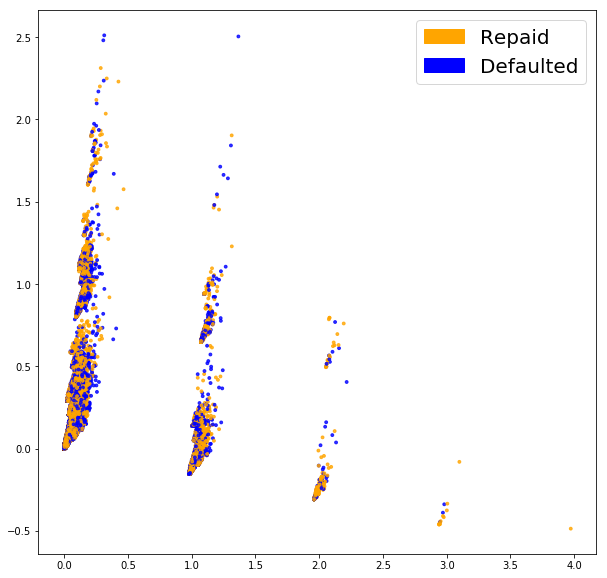

In [17]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = exp_df["clean_message_body"].tolist()
list_labels = exp_df["defaulted"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.33, random_state=42)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Repaid')
            green_patch = mpatches.Patch(color='blue', label='Defaulted')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [18]:
clf = LogisticRegression(C=30.0, class_weight={0: 0.66, 1: 0.34}, solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=42)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.713, precision = 0.713, recall = 0.713, f1 = 0.672


In [19]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

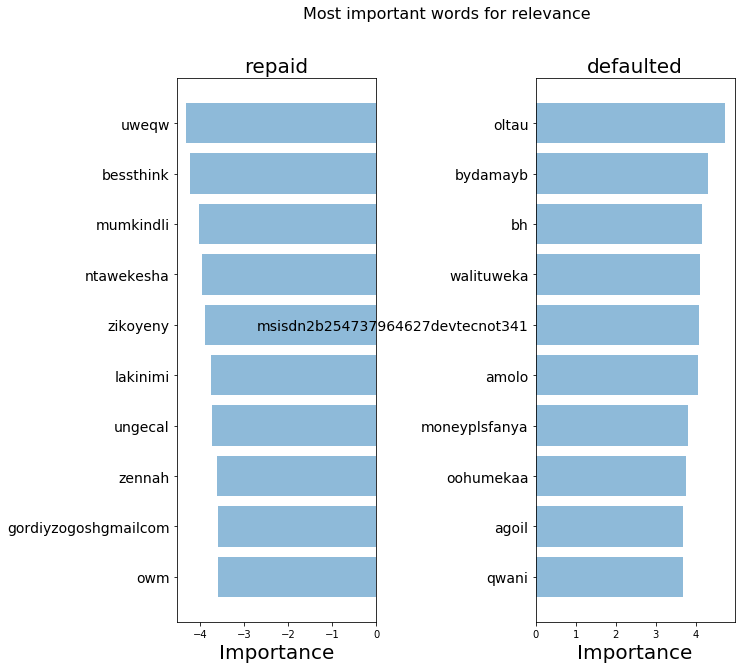

In [20]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('repaid', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('defaulted', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# Try TF-IDF per text sent from a user

In [21]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer() #(stop_words=all_stopwords)

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

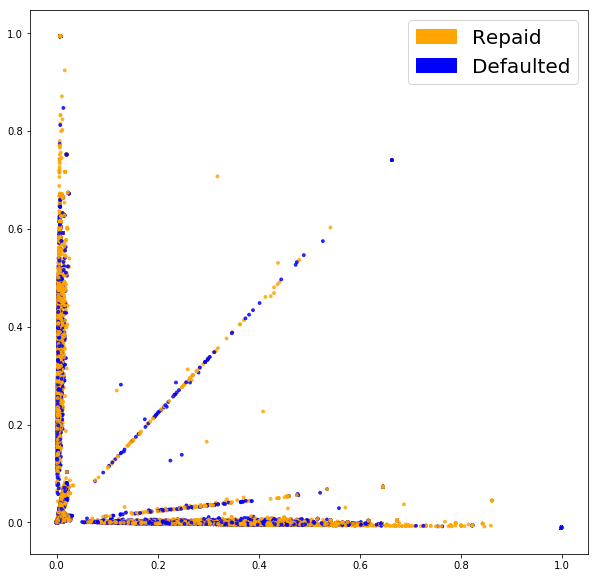

In [22]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [23]:
clf_tfidf = LogisticRegression(C=30.0, class_weight={0: 0.66, 1: 0.34}, solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=42)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.714, precision = 0.719, recall = 0.714, f1 = 0.671


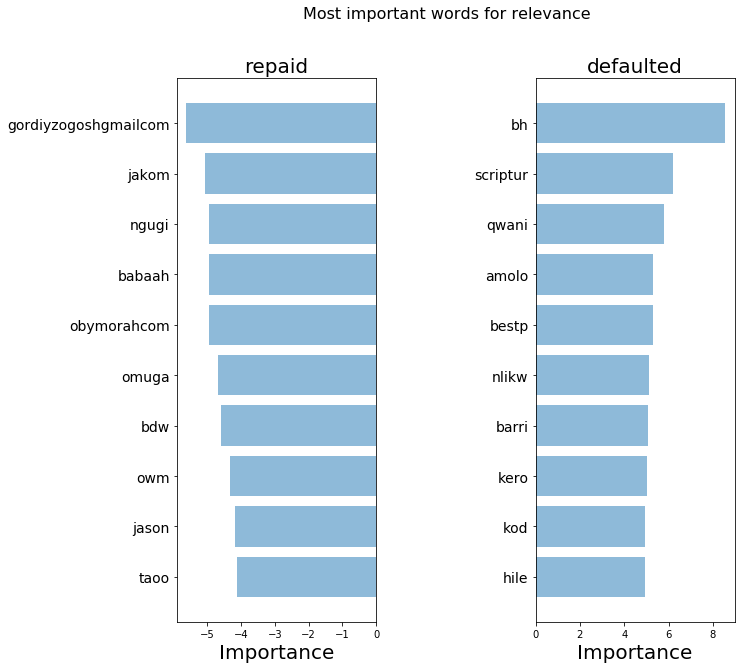

In [24]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# Try some stopwords... I stopped because it made the results worse

In [25]:
# path_all_stopwords = "../../../../data/stopwords-json/stopwords-all.json"

# with open(path_all_stopwords) as data_file:    
#     data = json.load(data_file)  

# stopwords_sw = json_normalize(data, ["sw"])
# stopwords_sw = list(stopwords_sw.iloc[:,0])

# stopwords_eng = ENGLISH_STOP_WORDS
# all_stopwords = stopwords_eng.union(stopwords_sw)

# Treat each users entire sent history as their text file for NLP... Doesn't work very well (scores are lower 0.6)

In [26]:
msf_df = standardize_text(msg_df, "message_body")
cmb_msgs = msg_df.groupby('user_id').apply(combine_messages).reset_index()

tokenizer = RegexpTokenizer(r'\w+')

cmb_msgs["tokens"] = cmb_msgs["text"].apply(tokenizer.tokenize)

In [27]:
cmb_msgs.head(11)

,user_id,text,tokens
0,user-1,"vipi? gd evening , uliniambia utanishow leo s...","[vipi, gd, evening, uliniambia, utanishow, leo..."
1,user-10,"juliana 0703800987 gambo 0707384031 sir,sorr...","[juliana, 0703800987, gambo, 0707384031, sir, ..."
2,user-100,"name mose njuguna ezekiel, tel 254791951582 ...","[name, mose, njuguna, ezekiel, tel, 2547919515..."
3,user-101,"pole beb,ol shal b wel swee am filin lonely th...","[pole, beb, ol, shal, b, wel, swee, am, filin,..."
4,user-102,morning uko aje sorry did'nt reply was totaly ...,"[morning, uko, aje, sorry, did, nt, reply, was..."
5,user-103,mr oketch how are you doing its long time s...,"[mr, oketch, how, are, you, doing, its, long, ..."
6,user-104,tungoje kwa bus za coast hizo ndizo tumeka m n...,"[tungoje, kwa, bus, za, coast, hizo, ndizo, tu..."
7,user-105,sasa hey siz unaeza niskumia za sapa? alafu ke...,"[sasa, hey, siz, unaeza, niskumia, za, sapa, a..."
8,user-106,i will do so nko chini bt let me try poa mrng ...,"[i, will, do, so, nko, chini, bt, let, me, try..."
9,user-107,4 mins remaining ndio dakika 10 ziishe zmeisha...,"[4, mins, remaining, ndio, dakika, 10, ziishe,..."


In [28]:
all_words = [word for tokens in cmb_msgs["tokens"] for word in tokens]
total_messages = [len(tokens) for tokens in cmb_msgs["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max words written by one user is %s" % max(total_messages))

2752517 words total, with a vocabulary size of 147667
Max words written by one user is 173813


In [29]:
nlp_df = loan_df.merge(cmb_msgs, on="user_id")
del nlp_df["repaid"]
del nlp_df["status"]
del nlp_df["disbursement_date"]

In [30]:
nlp_df.head()

,user_id,defaulted,text,tokens
0,user-1,1,"vipi? gd evening , uliniambia utanishow leo s...","[vipi, gd, evening, uliniambia, utanishow, leo..."
1,user-2,0,oky kwan unado nn leo aki btter ungekuwa kwako...,"[oky, kwan, unado, nn, leo, aki, btter, ungeku..."
2,user-3,1,iko kwa account ya kwikbet 1230 kama doo itak...,"[iko, kwa, account, ya, kwikbet, 1230, kama, d..."
3,user-4,0,short hehe why eeh and how was urs dia it was ...,"[short, hehe, why, eeh, and, how, was, urs, di..."
4,user-5,0,jp 1x12121112x21 3676 dc1x 4444 1 4056 dc1x 19...,"[jp, 1x12121112x21, 3676, dc1x, 4444, 1, 4056,..."


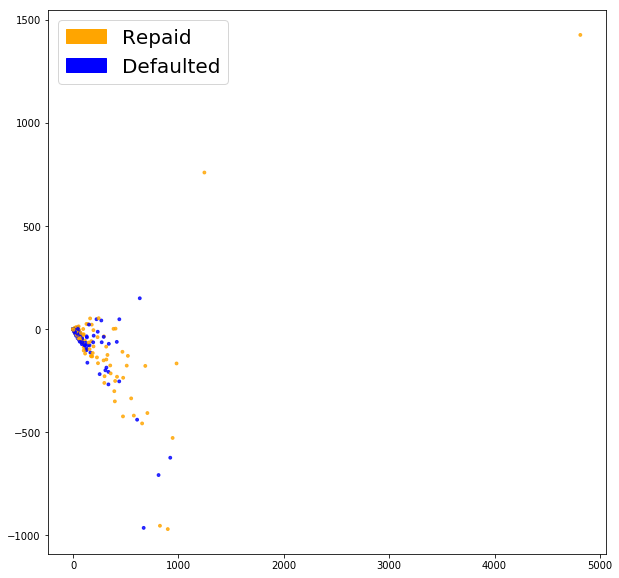

In [31]:
def cv(data):
    count_vectorizer = CountVectorizer(stop_words=all_stopwords)

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = nlp_df["text"].tolist()
list_labels = nlp_df["defaulted"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.33, random_state=42)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Repaid')
            green_patch = mpatches.Patch(color='blue', label='Defaulted')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})


fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [32]:
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=42)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.602, precision = 0.606, recall = 0.602, f1 = 0.595


In [33]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

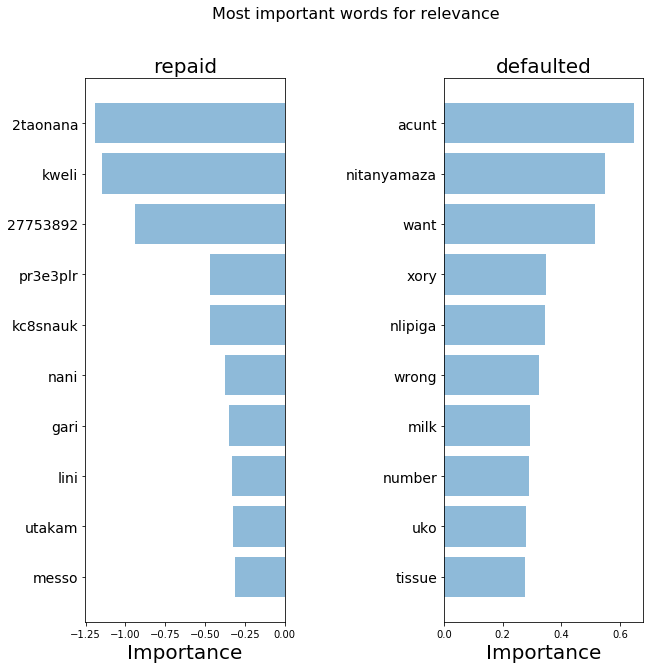

In [34]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('repaid', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('defaulted', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# TF-IDF for each user's group of sent messages

In [35]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer() #(stop_words=all_stopwords)

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

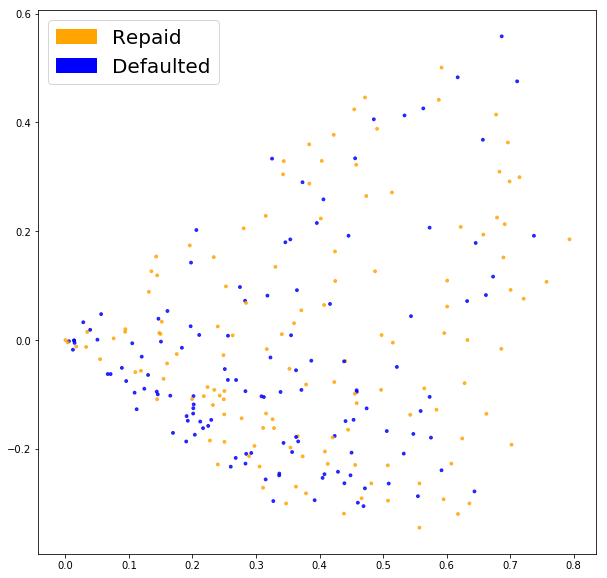

In [36]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [ ]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=42)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

In [ ]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

# word2vec! 

In [ ]:
documents = nlp_df.tokens.values

In [ ]:
model = gensim.models.Word2Vec(
        documents,
        size=150,
        window=10,
        min_count=2,
        workers=10)

model.train(documents, total_examples=len(documents), epochs=10)

In [ ]:
X = model[model.wv.vocab]

pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.scatter(result[:, 0], result[:, 1])